## Table of contents

1. [Windows Functions](#windows)  
    1.1 [Basic Windowing Syntax](#syntax)  
    1.2 [ROW_NUMBER()](#row)  
    1.3 [RANK() and DENSE_RANK()](#rank)  
    1.4 [NTILE](#ntile)  
    1.5 [LAG and LEAD](#lag)  
    1.6 [Windows Alias](#alias)  
2. [Performance Tuning](#performance)  
    2.1 [Reducing Table Size](#table)  
    2.2 [Making joins less complex](#joins)  
3. [Pivoting Data](#pivoting)  
    3.1 [Pivoting rows to columns](#rows)  
    3.2 [Pivoting columns to rows](#columns)  

### 1. Windows Functions <a id="windows"></a>
A window function performs a calculation across a set of table rows that are somehow related to the current row. This is comparable to the type of calculation that can be done with an aggregate function. But unlike regular aggregate functions, use of a window function does not cause rows to become grouped into a single output row — the rows retain their separate identities. Behind the scenes, the window function is able to access more than just the current row of the query result.

### 1.1 Basic Windowing Syntax <a id="syntax"></a>

In [1]:
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
df = pd.read_csv(r"D:\Documents\Internships\GymCounselor\SQL RKT\bikeshare.csv")
df.to_sql('bikes', engine)

In [4]:
df.dtypes

duration             object
duration_seconds    float64
start_time           object
start_station        object
start_terminal      float64
end_time             object
end_station          object
end_terminal        float64
bike_number          object
rider_type           object
id                    int64
dtype: object

In [5]:
pd.read_sql("""SELECT * FROM bikes LIMIT 1""", engine)

,index,duration,duration_seconds,start_time,start_station,start_terminal,end_time,end_station,end_terminal,bike_number,rider_type,id
0,0,0h 7m 55sec.,475.0,2012-01-01 00:04:00,7th & R St NW / Shaw Library,31245.0,2012-01-01 00:11:00,7th & T St NW,31109.0,W01412,Registered,1


Every station has a unique start terminal

#### OVER and ORDER BY

####  Find the running total which is the the sum of duration_seconds over the entire result set, in order by start_time.

In [3]:
pd.read_sql("""SELECT duration_seconds,
               SUM(duration_seconds) OVER (ORDER BY start_time) AS running_total
               FROM bikes
               LIMIT 10""", engine)

,duration_seconds,running_total
0,475.0,475.0
1,1162.0,2782.0
2,1145.0,2782.0
3,485.0,3738.0
4,471.0,3738.0
5,358.0,4096.0
6,1754.0,5850.0
7,259.0,6109.0
8,516.0,6625.0
9,913.0,7538.0


#### PARTITION BY 

####  Find the running total for each start_terminal, in order by start_time.

In [85]:
# first data is grouped and ordered on the basis of start_terminal
# within each start terminal, it is ordered by start time
# then for each group, the total duration is calculated


pd.read_sql("""SELECT start_terminal, start_time, 
               duration_seconds,
               SUM(duration_seconds) OVER
               (PARTITION BY start_terminal ORDER BY start_time)
                AS running_total
                FROM bikes
                WHERE start_time < '2012-01-08' LIMIT 10""", engine)

,start_terminal,start_time,duration_seconds,running_total
0,31000.0,2012-01-01 15:32:00,74.0,74.0
1,31000.0,2012-01-02 12:40:00,291.0,365.0
2,31000.0,2012-01-02 19:15:00,520.0,885.0
3,31000.0,2012-01-03 07:22:00,447.0,1756.0
4,31000.0,2012-01-03 07:22:00,424.0,1756.0
5,31000.0,2012-01-03 12:32:00,1422.0,3178.0
6,31000.0,2012-01-04 17:36:00,348.0,3526.0
7,31001.0,2012-01-01 02:20:00,162.0,162.0
8,31001.0,2012-01-01 13:35:00,2876.0,3038.0
9,31001.0,2012-01-01 13:36:00,2804.0,5842.0


* The `ORDER` and `PARTITION` define what is referred to as the "window"—the ordered subset of data over which calculations are made.
* Windows functions cannot be used in a `GROUP BY` clause.

### PARTITION BY vs Aggregate functions

#### Write a query modification of the above example query that shows the duration of each ride as a percentage of the total time accrued by riders from each start_terminal

In [87]:
pd.read_sql("""SELECT start_terminal,
               duration_seconds,
               (SUM(duration_seconds) OVER (PARTITION BY start_terminal ORDER BY start_time)) AS running_total1, 
               (SUM(duration_seconds) OVER (PARTITION BY start_terminal)) AS running_total2, 
               (duration_seconds/ (SUM(duration_seconds) OVER (PARTITION BY start_terminal)))*100 AS running_percentage
                FROM bikes
                WHERE start_time < '2012-01-08' LIMIT 10""", engine)

,start_terminal,duration_seconds,running_total1,running_total2,running_percentage
0,31000.0,74.0,74.0,3526.0,2.098695
1,31000.0,291.0,365.0,3526.0,8.252978
2,31000.0,520.0,885.0,3526.0,14.747589
3,31000.0,447.0,1756.0,3526.0,12.677255
4,31000.0,424.0,1756.0,3526.0,12.024957
5,31000.0,1422.0,3178.0,3526.0,40.328985
6,31000.0,348.0,3526.0,3526.0,9.869541
7,31001.0,162.0,162.0,29198.0,0.554833
8,31001.0,2876.0,3038.0,29198.0,9.849990
9,31001.0,2804.0,5842.0,29198.0,9.603397


In [36]:
pd.read_sql("""SELECT start_terminal,
               SUM(duration_seconds) AS running_total
               FROM bikes
               WHERE start_time < '2012-01-08' 
               GROUP BY start_terminal
               ORDER BY start_terminal
               LIMIT 10""", engine)

,start_terminal,running_total
0,31000.0,3526.0
1,31001.0,29198.0
2,31002.0,61063.0
3,31003.0,19227.0
4,31004.0,3703.0
5,31005.0,11518.0
6,31006.0,7672.0
7,31007.0,26372.0
8,31008.0,28781.0
9,31009.0,19328.0


#### Calculate the running total, running count and running average for every start terminal.

In [17]:
pd.read_sql("""SELECT start_terminal,
       duration_seconds,
       SUM(duration_seconds) OVER
         (PARTITION BY start_terminal ORDER BY start_time)
         AS running_total,
       COUNT(duration_seconds) OVER
         (PARTITION BY start_terminal ORDER BY start_time)
         AS running_count,
       AVG(duration_seconds) OVER
         (PARTITION BY start_terminal ORDER BY start_time)
         AS running_avg
        FROM bikes
        WHERE start_time < '2012-01-08'
        LIMIT 10""", engine)

,start_terminal,duration_seconds,running_total,running_count,running_avg
0,31000.0,74.0,74.0,1,74.000000
1,31000.0,291.0,365.0,2,182.500000
2,31000.0,520.0,885.0,3,295.000000
3,31000.0,447.0,1756.0,5,351.200000
4,31000.0,424.0,1756.0,5,351.200000
5,31000.0,1422.0,3178.0,6,529.666667
6,31000.0,348.0,3526.0,7,503.714286
7,31001.0,162.0,162.0,1,162.000000
8,31001.0,2876.0,3038.0,2,1519.000000
9,31001.0,2804.0,5842.0,3,1947.333333


### 1.2 ROW_NUMBER() <a id="row"></a>
This function assign a unique row number to each record.

The row number will be reset for each partition if PARTITION BY is specified. 


#### Get the row number ordered by start time.

In [19]:
pd.read_sql("""SELECT start_terminal,
       start_time,
       duration_seconds,
       ROW_NUMBER() OVER (ORDER BY start_time)
       AS row_number
       FROM bikes
       WHERE start_time < '2012-01-08'
       LIMIT 10""", engine)

,start_terminal,start_time,duration_seconds,row_number
0,31245.0,2012-01-01 00:04:00,475.0,1
1,31400.0,2012-01-01 00:10:00,1162.0,2
2,31400.0,2012-01-01 00:10:00,1145.0,3
3,31101.0,2012-01-01 00:15:00,485.0,4
4,31102.0,2012-01-01 00:15:00,471.0,5
5,31017.0,2012-01-01 00:17:00,358.0,6
6,31236.0,2012-01-01 00:18:00,1754.0,7
7,31101.0,2012-01-01 00:22:00,259.0,8
8,31014.0,2012-01-01 00:24:00,516.0,9
9,31101.0,2012-01-01 00:25:00,913.0,10


#### Get the row number for each start terminal ordered by start_time.

In [20]:
pd.read_sql("""SELECT start_terminal,
               start_time,
               duration_seconds,
               ROW_NUMBER() OVER (PARTITION BY start_terminal ORDER BY start_time)
               AS row_number
               FROM bikes
               WHERE start_time < '2012-01-08'
               LIMIT 10""", engine)

,start_terminal,start_time,duration_seconds,row_number
0,31000.0,2012-01-01 15:32:00,74.0,1
1,31000.0,2012-01-02 12:40:00,291.0,2
2,31000.0,2012-01-02 19:15:00,520.0,3
3,31000.0,2012-01-03 07:22:00,447.0,4
4,31000.0,2012-01-03 07:22:00,424.0,5
5,31000.0,2012-01-03 12:32:00,1422.0,6
6,31000.0,2012-01-04 17:36:00,348.0,7
7,31001.0,2012-01-01 02:20:00,162.0,1
8,31001.0,2012-01-01 13:35:00,2876.0,2
9,31001.0,2012-01-01 13:36:00,2804.0,3


### 2.3 RANK() and DENSE_RANK() <a id="rank"></a>

`RANK` is slightly different from `ROW_NUMBER` in the sense that if the column on the basis of which the rows are supposed to be ordered have the same value for two or more rows, `RANK` assigns the same rank to those rows whereas `ROW_NUMBER` assigns different numbers to each of those rows.

In [21]:
pd.read_sql("""SELECT start_terminal,
               duration_seconds,
               RANK() OVER (PARTITION BY start_terminal ORDER BY start_time) AS rank
               FROM bikes
               WHERE start_time < '2012-01-08'
               LIMIT 10""", engine)

,start_terminal,duration_seconds,rank
0,31000.0,74.0,1
1,31000.0,291.0,2
2,31000.0,520.0,3
3,31000.0,447.0,4
4,31000.0,424.0,4
5,31000.0,1422.0,6
6,31000.0,348.0,7
7,31001.0,162.0,1
8,31001.0,2876.0,2
9,31001.0,2804.0,3


#### Write a query that shows the 5 longest rides from each starting terminal, ordered by terminal, and longest to shortest rides within each terminal. Limit to rides that occurred before Jan. 8, 2012.

In [35]:
pd.read_sql("""SELECT *
                  FROM (
                SELECT start_terminal,
                start_time,
                duration_seconds AS trip_time,
                RANK() OVER (PARTITION BY start_terminal ORDER BY duration_seconds DESC) AS rank
                FROM bikes
                WHERE start_time < '2012-01-08'
                       ) sub
                WHERE sub.rank <= 5
                LIMIT 10""", engine)

,start_terminal,start_time,trip_time,rank
0,31000.0,2012-01-03 12:32:00,1422.0,1
1,31000.0,2012-01-02 19:15:00,520.0,2
2,31000.0,2012-01-03 07:22:00,447.0,3
3,31000.0,2012-01-03 07:22:00,424.0,4
4,31000.0,2012-01-04 17:36:00,348.0,5
5,31001.0,2012-01-01 15:09:00,3624.0,1
6,31001.0,2012-01-01 15:09:00,3598.0,2
7,31001.0,2012-01-01 13:35:00,2876.0,3
8,31001.0,2012-01-01 13:36:00,2804.0,4
9,31001.0,2012-01-01 13:38:00,2686.0,5


If three entries have same value,

`RANK()` would give the identical rows a rank of 2, then skip ranks 3 and 4, so the next result would be 5.  
`DENSE_RANK()` would still give all the identical rows a rank of 2, but the following row would be 3—no ranks would be skipped.

### 2.4 NTILE <a id="ntile"></a>
Windows functions can be used to identify what percentile (or quartile, or any other subdivision) a given row falls into.   
The syntax is `NTILE(*# of buckets*)`. 

* When data is arranged in ascending order, making three divisions such that data is divided into four parts would be quartile.
* If there are 10 rows for example, which has to be split into 4 equal parts, each part should ahve 2.5 observations but since row number should be a integer, SQL assigns first three rows to the first quartile and next 2 rows to the second quartiles.


In [39]:
# quartile divides the data into 4 equal parts
# quintile divides the data into 5 equal parts
# percentile divides the data into 100 equal parts

pd.read_sql("""SELECT start_terminal,
               duration_seconds,
               NTILE(4) OVER
              (PARTITION BY start_terminal ORDER BY duration_seconds) AS quartile, 
               NTILE(5) OVER
              (PARTITION BY start_terminal ORDER BY duration_seconds) AS quintile,
              NTILE(100) OVER
              (PARTITION BY start_terminal ORDER BY duration_seconds) AS percentile
              FROM bikes
              WHERE start_time < '2012-01-08'
              ORDER BY start_terminal, duration_seconds
              LIMIT 10""", engine)

,start_terminal,duration_seconds,quartile,quintile,percentile
0,31000.0,74.0,1,1,1
1,31000.0,291.0,1,1,2
2,31000.0,348.0,2,2,3
3,31000.0,424.0,2,2,4
4,31000.0,447.0,3,3,5
5,31000.0,520.0,3,4,6
6,31000.0,1422.0,4,5,7
7,31001.0,5.0,1,1,1
8,31001.0,47.0,1,1,2
9,31001.0,138.0,1,1,3


### 2.5 LAG and LEAD <a id="lag"></a>
If the data is in a meaningful order and we wish to see the previous observation or the next observation or both in the present row, LAG and LEAD can be used.

In [42]:
pd.read_sql("""SELECT start_terminal,
               duration_seconds,
               LAG(duration_seconds, 1) OVER
               (PARTITION BY start_terminal ORDER BY duration_seconds) AS lag,
               LEAD(duration_seconds, 1) OVER
               (PARTITION BY start_terminal ORDER BY duration_seconds) AS lead
               FROM bikes
               WHERE start_time < '2012-01-08'
               ORDER BY start_terminal, duration_seconds
               LIMIT 10""", engine)

,start_terminal,duration_seconds,lag,lead
0,31000.0,74.0,NaN,291.0
1,31000.0,291.0,74.0,348.0
2,31000.0,348.0,291.0,424.0
3,31000.0,424.0,348.0,447.0
4,31000.0,447.0,424.0,520.0
5,31000.0,520.0,447.0,1422.0
6,31000.0,1422.0,520.0,NaN
7,31001.0,5.0,NaN,47.0
8,31001.0,47.0,5.0,138.0
9,31001.0,138.0,47.0,138.0


For every start terminal, the lag variable for the first observation and the lead variable for the last observation will be NaN.

### 2.6 Window Alias <a id="alias"></a>

If a particular window is to be used repeatedly, it can be given an alias. Windows should always be specified after Where condition.

In [44]:
pd.read_sql("""SELECT start_terminal,
       duration_seconds,
       NTILE(4) OVER ntile_window AS quartile,
       NTILE(5) OVER ntile_window AS quintile,
       NTILE(100) OVER ntile_window AS percentile
       FROM bikes
       WHERE start_time < '2012-01-08'
       WINDOW ntile_window AS
         (PARTITION BY start_terminal ORDER BY duration_seconds)
        ORDER BY start_terminal, duration_seconds
        LIMIT 10""", engine)

,start_terminal,duration_seconds,quartile,quintile,percentile
0,31000.0,74.0,1,1,1
1,31000.0,291.0,1,1,2
2,31000.0,348.0,2,2,3
3,31000.0,424.0,2,2,4
4,31000.0,447.0,3,3,5
5,31000.0,520.0,3,4,6
6,31000.0,1422.0,4,5,7
7,31001.0,5.0,1,1,1
8,31001.0,47.0,1,1,2
9,31001.0,138.0,1,1,3


### 2. Performance Tuning <a id="performance"></a>

Few factors that affect query run time:
* Table size: If your query hits one or more tables with millions of rows or more, it could affect performance.
* Joins: If your query joins two tables in a way that substantially increases the row count of the result set, your query is likely to be slow. There's an example of this in the subqueries lesson.
* Aggregations: Combining multiple rows to produce a result requires more computation than simply retrieving those rows.

### 2.1 Reducing Table Size <a id="table"></a>
Fltering the data on the basis of a specific condition or using the LIMIT function.

#### Filtering data on the basis of start time.

In [49]:
pd.read_sql("""SELECT * FROM bikes 
                WHERE start_time BETWEEN "1/1/2012%" AND "3/1/2012%"  
                LIMIT 5""", engine)

,index,duration,duration_seconds,start_time,start_station,start_terminal,end_time,end_station,end_terminal,bike_number,rider_type,id
0,0,0h 7m 55sec.,475.0,2012-01-01 00:04:00,7th & R St NW / Shaw Library,31245.0,2012-01-01 00:11:00,7th & T St NW,31109.0,W01412,Registered,1
1,1,0h 19m 22sec.,1162.0,2012-01-01 00:10:00,Georgia & New Hampshire Ave NW,31400.0,2012-01-01 00:29:00,16th & Harvard St NW,31103.0,W00524,Casual,2
2,2,0h 19m 5sec.,1145.0,2012-01-01 00:10:00,Georgia & New Hampshire Ave NW,31400.0,2012-01-01 00:29:00,16th & Harvard St NW,31103.0,W00235,Registered,3
3,3,0h 8m 5sec.,485.0,2012-01-01 00:15:00,14th & V St NW,31101.0,2012-01-01 00:23:00,Park Rd & Holmead Pl NW,31602.0,W00864,Registered,4
4,4,0h 7m 51sec.,471.0,2012-01-01 00:15:00,11th & Kenyon St NW,31102.0,2012-01-01 00:23:00,7th & T St NW,31109.0,W00995,Registered,5


### 2.2 Making joins less complex <a id="joins"></a>

Joins can be made less complex using subqeries.
In order to make joins simple and reduce query time, if data has to be aggregated on the basis of two columns such that one column is in table1 and the other in table2, then grouping the data in table2 before joining would reduce query time. 

In [56]:
df2 = pd.read_csv(r"D:\Documents\Internships\GymCounselor\SQL RKT\players.csv")
df2.to_sql('players', con=engine)

In [57]:
df2.columns

Index(['full_school_name', 'school_name', 'player_name', 'position', 'height',
       'weight', 'year', 'hometown', 'state', 'id'],
      dtype='object')

In [58]:
df3 = pd.read_csv(r"D:\Documents\Internships\GymCounselor\SQL RKT\teams.csv")
df3.to_sql('teams', con=engine)

In [59]:
df3.columns

Index(['division', 'conference', 'school_name', 'roster_url', 'id'], dtype='object')

#### Find the number of players from each school in each conference.

In [61]:
# tables are joined and then grouped on the basis of conference and school name

pd.read_sql("""SELECT teams.conference AS conference,
               players.school_name,
               COUNT(1) AS players
              FROM players
              JOIN teams
              ON teams.school_name = players.school_name
              GROUP BY 1,2 LIMIT 10""", engine)

,conference,school_name,players
0,ACC,Boston College,94
1,ACC,Clemson,118
2,ACC,Duke,112
3,ACC,Florida State,132
4,ACC,Georgia Tech,115
5,ACC,Maryland,108
6,ACC,Miami (FL),110
7,ACC,North Carolina,125
8,ACC,North Carolina State,114
9,ACC,Pittsburgh,99


In [62]:
# first players table is grouped on the basis of school name and then 
# joined to find number of players from each school in each conference

pd.read_sql("""SELECT teams.conference,
               sub.*
               FROM (
                    SELECT players.school_name,
                    COUNT(*) AS players
                    FROM players
                    GROUP BY 1
                   ) sub
              JOIN  teams
              ON teams.school_name = sub.school_name LIMIT 10""", engine)

,conference,school_name,players
0,American Athletic,Cincinnati,111
1,American Athletic,Connecticut,106
2,American Athletic,Houston,120
3,American Athletic,Louisville,115
4,American Athletic,Memphis,125
5,American Athletic,Rutgers,113
6,American Athletic,South Florida,113
7,American Athletic,Southern Methodist,110
8,American Athletic,Temple,113
9,American Athletic,UCF,98


In [67]:
"""EXPLAIN
SELECT *
  FROM benn.sample_event_table
 WHERE event_date >= '2014-03-01'
   AND event_date < '2014-04-01'
 LIMIT 100"""

"EXPLAIN\nSELECT *\n  FROM benn.sample_event_table\n WHERE event_date >= '2014-03-01'\n   AND event_date < '2014-04-01'\n LIMIT 100"

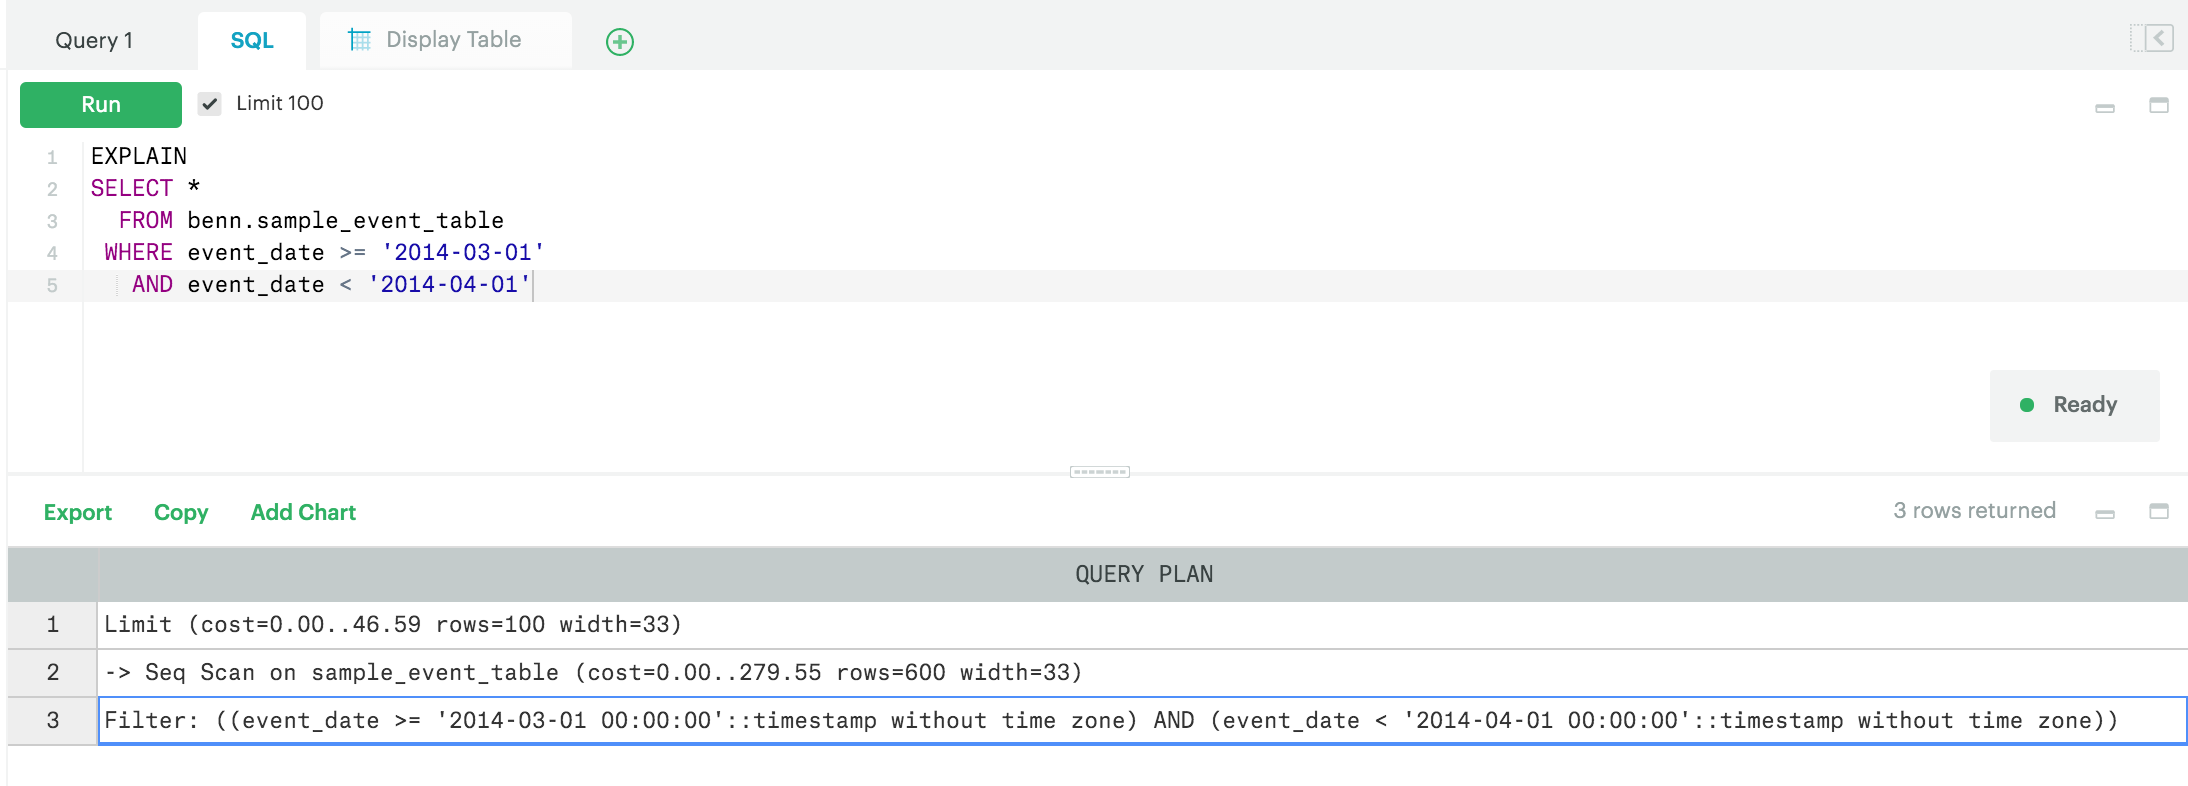

### 3. Pivoting Data in SQL <a id="pivoting"></a>

### 3.1 Pivoting rows to columns <a id="rows"></a>
#### Find the number of players for each category in year for each conference.

In [73]:
pd.read_sql("""SELECT teams.conference AS conference,
               players.year,
               COUNT(1) AS players
          FROM players
          JOIN teams
            ON teams.school_name = players.school_name
         GROUP BY 1,2
         LIMIT 7""", engine)

,conference,year,players
0,ACC,FR,607
1,ACC,JR,356
2,ACC,SO,341
3,ACC,SR,259
4,American Athletic,FR,418
5,American Athletic,JR,241
6,American Athletic,SO,247


In [71]:
# first joined and grouped the data on the basis of conference and year
# then created specific columns for each category in year

pd.read_sql("""SELECT conference,
        players, 
       SUM(CASE WHEN year = 'FR' THEN players ELSE NULL END) AS fr,
       SUM(CASE WHEN year = 'SO' THEN players ELSE NULL END) AS so,
       SUM(CASE WHEN year = 'JR' THEN players ELSE NULL END) AS jr,
       SUM(CASE WHEN year = 'SR' THEN players ELSE NULL END) AS sr
  FROM (
        SELECT teams.conference AS conference,
               players.year,
               COUNT(1) AS players
          FROM players
          JOIN teams
            ON teams.school_name = players.school_name
         GROUP BY 1,2
       ) sub
 GROUP BY 1
 ORDER BY 1
 LIMIT 7""", engine)

,conference,fr,so,jr,sr
0,ACC,607,341,356,259
1,American Athletic,418,247,241,218
2,Big 12,456,254,270,210
3,Big Sky,442,273,249,234
4,Big South,181,102,94,188
5,Big Ten,636,314,284,232
6,CAA,335,242,226,243


### 3.2 Pivoting columns to rows <a id="columns"></a>
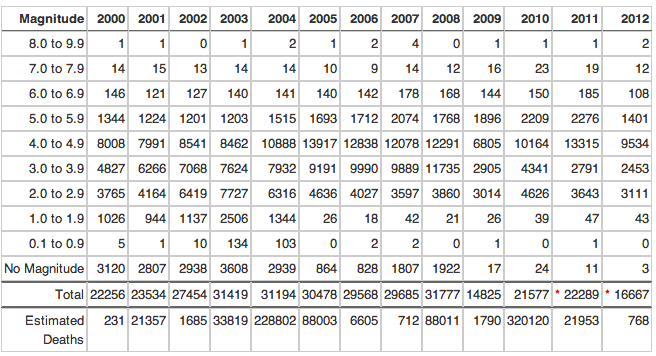

In order to dispay the data with three columns : magnitude, year and number of earthquakes.

In [82]:
"""SELECT year
  FROM (VALUES (2000),(2001),(2002),(2003),(2004),(2005),(2006),
               (2007),(2008),(2009),(2010),(2011),(2012)) v(year)"""

'SELECT year\n  FROM (VALUES (2000),(2001),(2002),(2003),(2004),(2005),(2006),\n               (2007),(2008),(2009),(2010),(2011),(2012)) v(year)'

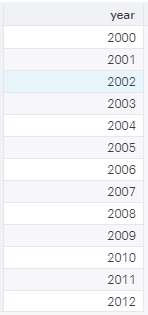

In [83]:
"""SELECT years.*,
       earthquakes.*
        FROM earthquakes
         CROSS JOIN (
       SELECT year
         FROM (VALUES (2000),(2001),(2002),(2003),(2004),(2005),(2006),
                      (2007),(2008),(2009),(2010),(2011),(2012)) v(year)
       ) years"""

'SELECT years.*,\n       earthquakes.*\n        FROM earthquakes\n         CROSS JOIN (\n       SELECT year\n         FROM (VALUES (2000),(2001),(2002),(2003),(2004),(2005),(2006),\n                      (2007),(2008),(2009),(2010),(2011),(2012)) v(year)\n       ) years'

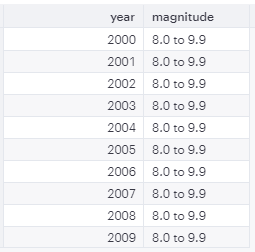

In [ ]:
"""SELECT years.*,
                   earthquakes.magnitude,
                   CASE year
                 WHEN 2000 THEN year_2000
                 WHEN 2001 THEN year_2001
                 WHEN 2002 THEN year_2002
                 WHEN 2003 THEN year_2003
                 WHEN 2004 THEN year_2004
                 WHEN 2005 THEN year_2005
                 WHEN 2006 THEN year_2006
                 WHEN 2007 THEN year_2007
                 WHEN 2008 THEN year_2008
                 WHEN 2009 THEN year_2009
                 WHEN 2010 THEN year_2010
                 WHEN 2011 THEN year_2011
                 WHEN 2012 THEN year_2012
                 ELSE NULL END
                 AS number_of_earthquakes
          FROM earthquakes
         CROSS JOIN (
                   SELECT year
                   FROM (VALUES (2000),(2001),(2002),(2003),(2004),(2005),(2006),
                      (2007),(2008),(2009),(2010),(2011),(2012)) v(year)
                   ) years"""

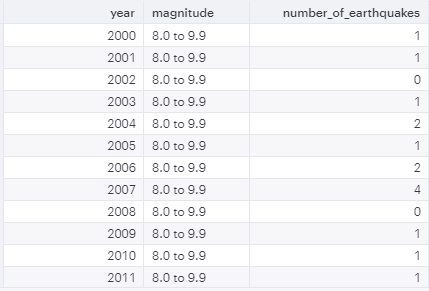